# [Going Deeper CV 6] 자율주행 보조 시스템 만들기

Object Detection을 사용하여 자율주행에 필요한 모델을 만들어 보는 프로젝트이다.   
모델을 설계하여 미니 자율주행 차를 만들어보는데, 앞에 사람이나 물체가 있을 시 가야할지 멈춰야할지를 판단해주는 모델이다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

먼저 필요한 라이브러리를 준비한다

다음으로는 KITTI 데이터셋 다운로드하여 준비한다.

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### 데이터셋 확인

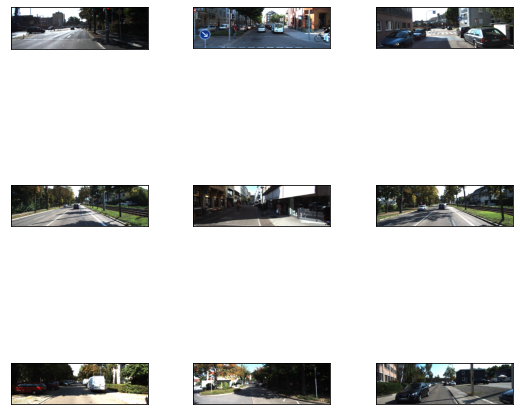

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

많은 부분을 볼 수 있도록 광곽 이미지들이 준비되어 있다.

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj58/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

### KITTI 데이터셋 중 하나를 가져와서 바운딩 박스 그려보기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.53,  2.26,  1.86], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.47208   , 0.49223027, 0.5980267 , 0.52979064],
       [0.26712   , 0.        , 0.50853336, 0.09436393],
       [0.45741335, 0.3075443 , 0.50784   , 0.33874395]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.85,  2.63, 12.34],
       [ 1.84,  2.04,  4.33],
       [ 1.39,  1.82,  4.11]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[  1.9 ,   1.58,  50.19],
       [-13.63,   2.12,  16.23],
       [-16.37,   2.33,  56.71]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 3, 0])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.49,  1.57,  1.58], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float

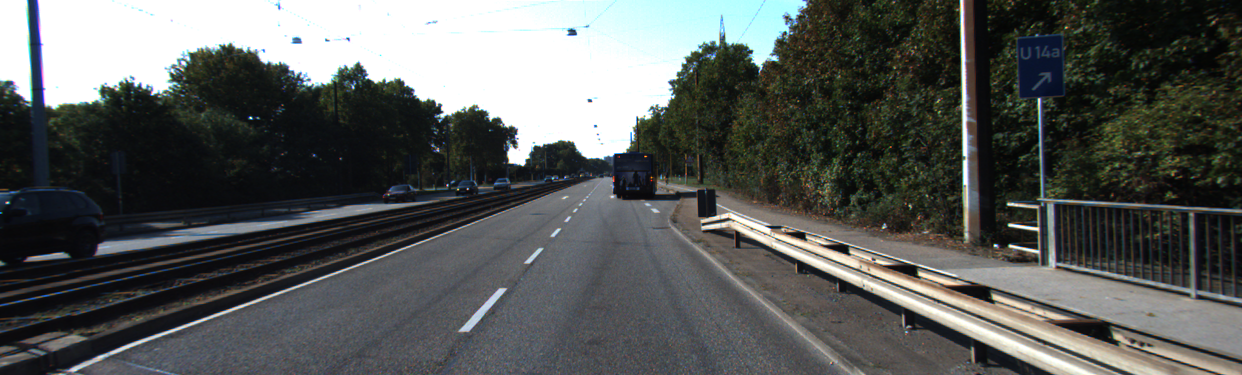

In [4]:
TakeDataset = ds_train.take(1)

for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

데이터셋에서 이미지 한장을 뽑아 준비한다. 그리고 아래 `visualize_bbox`함수를 사용하여 바운딩 박스를 찾아본다.

width: 1242  height: 375
(3, 4)
[611.35    197.97    658.      150.73999]
[  0.      274.83002 117.2     184.29999]
[381.97    203.47    420.72    184.56001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F19F038F990>


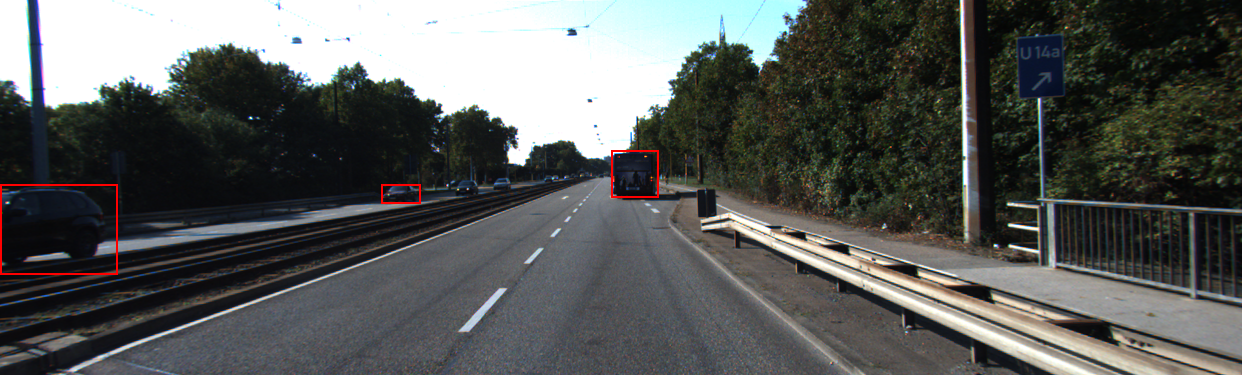

In [5]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## Keras-retinanet 모델 준비

### (1) 데이터 포맷 변경

In [7]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [16:26<00:00,  6.43it/s]


In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:58<00:00,  6.01it/s]


### 클래스 맵핑

In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## (2) 셋팅

In [13]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

Traceback (most recent call last):
  File "keras-retinanet/keras_retinanet/bin/train.py", line 38, in <module>
    from ..callbacks.eval import Evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/callbacks/eval.py", line 18, in <module>
    from ..utils.eval import evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/utils/eval.py", line 26, in <module>
    import progressbar
ModuleNotFoundError: No module named 'progressbar'


In [14]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

You are using tensorflow version 2.2.0. The minimum required version is 2.3.0 (blacklisted: []).


알수 없는 이유로 Retina model이 학습되지 않는다.... 프로젝트를 진행하기가 어렵다.

## 1. 자율주행 시스템 만들기

RetinaNet 모델을 사용하여 아래 조건에 맞는 함수를 만든다.

- 입력으로 이미지 경로를 받습니다.   
   
   
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.   
   
   
- 조건은 다음과 같습니다.
    * 사람이 한 명 이상 있는 경우
    * 차량의 크기(width or height)가 300px이상인 경우

In [12]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    pass
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))

None


## 2. 자율주행 시스템 평가하기

`test_system` 함수를 사용하여 위 조건에 맞게 만든 함수를 테스트한다. 10장의 사진으로 GO or STOP이 잘 작동하는지 확인한다.

In [13]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

0점입니다.



# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- 텐서플로우 GPU 환경을 맞추는데 어려움이 있었다.
- 그 이외에 진행하는데 큰 어려움은 없었으나 쥬피터 노트북에서 모델 학습이 진행되지 않는 에러가 생겨서 진행하지 못했다.

## 2. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.
KITTI 데이터셋에 대한 분석을 진행하였다.
2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다  
3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.   
2번, 3번 루브릭은 진행하지 못하였다.
   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
LMS에서는 잘 되는 모델 학습 부분이 쥬피터 노트북에서는 진행이 되지 않았다. 시간 상 여유가 없어 프로젝트를 완료하지 못하고 제출을 한다.
   
### 5. **자기 다짐**   
이번 프로젝트에서는 자율주행에서 사용되는 이미지 detection을 활용한 모델을 만들어보는 프로젝트였다. 자율주행은 인공지능 분야에서 가장 활발하게 연구되고 있는 분야로서 큰 관심을 가지고 있었고, 결과물을 만들어보고 싶었는데 여건상 에러가 생겨 진행하지 못하여서 너무 아쉽다. 기회가 된다면 이후에 노드를 다시 진행하여 더 발전된 모델을 만들어보고 싶다.  